# Лабораторная работа 3: Перенос знаний с использованием PyTorch

## Цели работы

Цель данной работы — изучить и реализовать метод переноса знаний (transfer learning) в глубоких нейронных сетях для решения задачи классификации отходов на основе набора данных [Garbage Classification]
(https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification). Предлагается применение метода переноса знаний к известным моделям глубокого обучения, обученных на наборе данных ImageNet.

## Перенос знаний

Перенос знаний — это метод, который позволяет улучшить сходимость модели на новых данных за счет лучшей начальной инициализации модели. В качестве начальной инициализации в таком случае выступают веса  полученной на исходном наборе данных. Этот подход часто применяется в задачах, где имеется мало данных, но есть смежный набор данных с обученной моделью.

Данный подход предполагает использование весов нейронной сети, обученной на одних данных, для начальной инициализации весов в другой, смежной задаче. В задачах классификации этот подход обычно предполагает изменение последнего слоя, поскольку количество нейронов в последнем слое определяется количеством классов в исходном наборе данных. Например, модель, обученная на ImageNet, будет иметь 1000 нейронов на последнем слое, а модель, обученная на MNIST, будет иметь 10 нейронов. Существуют различные подходы к переносу знаний:

- Обучение всех весов нейронной сети
- Обучение весов слоев, которые были добавлены или изменены
- Обучение нескольких последних слоев
- Обучение части слоев нейронной сети

Любая подобная конфигурация является допустимой и может помочь в решении задачи. Для определения наилучшей конфигурации необходимо провести эксперименты.

В задачах классификации последний слой обычно заменяют на один или несколько слоев. Количество нейроннов в последнем слое при это должно быть равно количеству классов в новом наборе данных. Вместо последнего слоя также можно использовать классические модели машинного обучения, данный подход **нельзя** использовать в этой лабораторной работе!

##  Требования
1. Необходимо выполнить и отобразить в Jupyter следующие задачи:

    - Загрузить и проверить данные, включая демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей.
    - Загрузить 4 нейронные сети (можно использовать torchvision), обученные на наборе данных ImageNet. Требуется для каждой модели провести 2 эксперимента, используя разные конфигурация переноса знаний. Модифицировать последний слой и реализовать обучение на наборе данных Garbage Classification. Настроить гиперпараметры обучения.
    - Построить F1-score от количества эпох для всех моделей на валидационных данных. Построить сравнительную столбчатую диаграмму точностей: модель и тип эксперимента (с кратким указанием параметров) по горизонтали, F1 score на тестовых данных по вертикали.

2. Проверка корректности:

    - Разделите датасет на тренировочную, валидационную и тестовую выборки самостоятельно в соотношении 70/15/15.
    - Для оценки качества следует использовать Macro [F1-score](https://en.wikipedia.org/wiki/F-score), поскольку датасет не сбалансирован.

3. Архитектуры:

    - Можно использовать любые сверточные архитектуры или архитектуры на базе механизма внимания (transformer, ViT).
    - Хорошее понимание работы выбранных архитектур напрямую влияет на количество баллов за "знание". Будьте готовы кратко рассказать о примечательных особенностях выбранных или одной из выбранных архитектур при очной сдаче лабораторной работы. Не бойтесь выбирать сложные архитектуры - чем сложнее архитектура, тем больше шансов рассказать про нее что-то интересное и примечательное.
    

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision import models
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Subset

## Загрузка набора данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
data_dir = '/content/drive/My Drive/Garbage classification/Garbage classification'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print(f"Dataset size: {len(dataset)}")
print(f"Classes: {dataset.classes}")

Dataset size: 2527
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Разделение датасета и проверка размерностей

In [42]:
batch_size = 64
dataset_size = len(dataset)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_end = int(0.7 * dataset_size)
val_end = train_end + int(0.15 * dataset_size)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

print(f"Train_data size: {len(train_dataset)}")
print(f"Val_data size: {len(val_dataset)}")
print(f"Test_data size: {len(test_dataset)}")

Train_data size: 1768
Val_data size: 379
Test_data size: 380


## Визуализация изображений с соответствующими метками

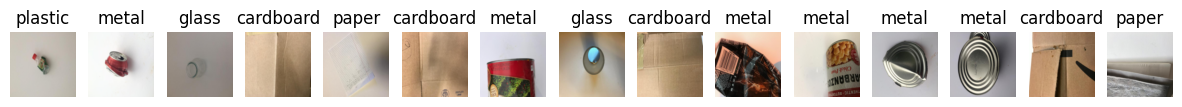

In [43]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
def show_images(dataset, num_images=15):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        r = random.randint(1, len(dataset))
        img, label = dataset[r]
        img = img.permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis('off')
    plt.show()

show_images(dataset)

## Архитектуры

#### VGG-16

In [44]:
def vgg16_classic(num_classes: int):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.features[-6:].parameters():
        param.requires_grad = True

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

def vgg16_modified(num_classes: int):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.features[24:].parameters():
        param.requires_grad = True

    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((7, 7))
    )

    model.classifier = nn.Sequential(
        nn.Linear(256 * 7 * 7, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes)
    )
    return model

#### EfficientNet-B0

In [45]:
def efficientnet_b0_classic(num_classes: int):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def efficientnet_b0_modified(num_classes: int):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.5),
        nn.Linear(model.classifier[1].in_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p = 0.5),
        nn.Linear(512, num_classes)
    )
    return model

#### Shufflenet_v2

In [46]:
def shufflenet_classic(num_classes: int):
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def shufflenet_modified(num_classes: int):
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, num_classes)
    )
    return model

#### MobileNetV2

In [47]:
def mobilenet_v2_classic(num_classes: int):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def mobilenet_v2_modified(num_classes: int):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    conv_block = nn.Sequential(
        nn.Conv2d(in_channels=1280, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    old_feature = model.features[-1]
    model.features[-1] = nn.Sequential(old_feature, conv_block)

    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

## Настройка гиперпараметров

In [48]:
classes = dataset.classes
epochs = 20
learning_rate = 0.001

## Обучение моделей

In [51]:
@torch.no_grad()
def f1_calc(model, dataloader: DataLoader):
    device = next(model.parameters()).device
    f1_all = []
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_all.append(f1)
    return sum(f1_all) / len(f1_all)

@torch.no_grad()
def accuracy(model, dataloader: DataLoader):
    device = next(model.parameters()).device
    correct = 0
    total = 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

def train_model(model, name, train_loader, val_loader, epochs, learning_rate):
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0
    val_f1_stat = []

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_train_correct = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total_train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = total_train_correct / total_train
        train_time = time.time() - start_time

        start_time = time.time()
        val_f1 = f1_calc(model, val_loader)
        val_accuracy = accuracy(model, val_loader)
        val_time = time.time() - start_time

        if val_f1 > best_f1:
            torch.save(model.state_dict(), f"best_{name}.pth")
            best_f1 = val_f1

        val_f1_stat.append(val_f1)

        print(f'Epoch [{epoch + 1}/{epochs}]')
        print(f'Train time = {train_time:.4f} seconds, Train accuracy = {train_accuracy:.4f}')
        print(f"Validation time = {val_time:.4f} seconds, Validation F1 = {val_f1:.4f}, Validation accuracy = {val_accuracy:.4f}")
        print()

    test_accuracy = accuracy(model, test_loader)
    print(f'Test accuracy = {test_accuracy:.4f}')

    return val_f1_stat

test_f1_stat = {}

def run_experiment(model_factory):
    global test_f1_stat
    model = model_factory(len(classes)).to(device)
    name = model_factory.__name__
    val_f1_stat = train_model(model, name, train_loader, val_loader, epochs, learning_rate)
    model.load_state_dict(torch.load(f'best_{name}.pth', weights_only=True))
    test_f1 = f1_calc(model, test_loader)
    print(f'Test F1 = {test_f1:.4f}')
    plt.plot(range(epochs), val_f1_stat, marker='o')
    plt.title(f'{name} validation')
    plt.xlabel('epochs')
    plt.xticks([i for i in range(epochs)])
    plt.ylabel('F1 score')
    plt.grid()
    plt.show()
    test_f1_stat[name] = test_f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Эксперименты

#### VGG-16

Epoch [1/20]
Train time = 14.3105 seconds, Train accuracy = 0.5549
Validation time = 36.5114 seconds, Validation F1 = 0.5846, Validation accuracy = 0.6702

Epoch [2/20]
Train time = 14.1613 seconds, Train accuracy = 0.7121
Validation time = 5.4767 seconds, Validation F1 = 0.5418, Validation accuracy = 0.6517

Epoch [3/20]
Train time = 14.5367 seconds, Train accuracy = 0.7817
Validation time = 5.6474 seconds, Validation F1 = 0.6521, Validation accuracy = 0.7177

Epoch [4/20]
Train time = 14.9618 seconds, Train accuracy = 0.8088
Validation time = 5.1803 seconds, Validation F1 = 0.6925, Validation accuracy = 0.7335

Epoch [5/20]
Train time = 14.2239 seconds, Train accuracy = 0.8795
Validation time = 5.1357 seconds, Validation F1 = 0.7301, Validation accuracy = 0.7704

Epoch [6/20]
Train time = 14.3476 seconds, Train accuracy = 0.9033
Validation time = 5.3517 seconds, Validation F1 = 0.7135, Validation accuracy = 0.7652

Epoch [7/20]
Train time = 13.7416 seconds, Train accuracy = 0.9333
Va

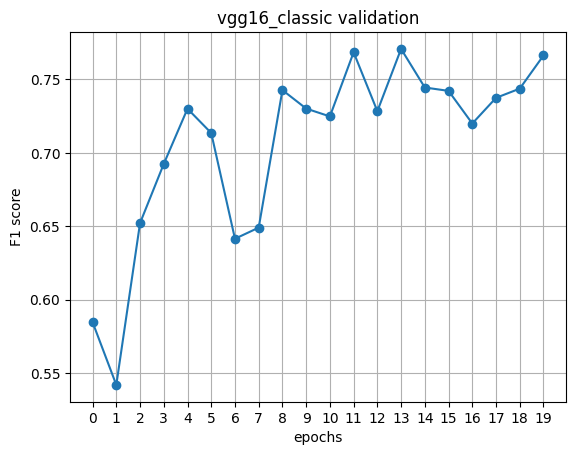

In [52]:
run_experiment(vgg16_classic)

Epoch [1/20]
Train time = 13.0975 seconds, Train accuracy = 0.6821
Validation time = 5.0982 seconds, Validation F1 = 0.6360, Validation accuracy = 0.7018

Epoch [2/20]
Train time = 13.1047 seconds, Train accuracy = 0.8880
Validation time = 5.6874 seconds, Validation F1 = 0.7212, Validation accuracy = 0.7757

Epoch [3/20]
Train time = 13.1607 seconds, Train accuracy = 0.9457
Validation time = 5.0152 seconds, Validation F1 = 0.6746, Validation accuracy = 0.7124

Epoch [4/20]
Train time = 12.8014 seconds, Train accuracy = 0.9666
Validation time = 5.0183 seconds, Validation F1 = 0.8213, Validation accuracy = 0.8391

Epoch [5/20]
Train time = 13.0378 seconds, Train accuracy = 0.9745
Validation time = 5.9482 seconds, Validation F1 = 0.8103, Validation accuracy = 0.8338

Epoch [6/20]
Train time = 12.9750 seconds, Train accuracy = 0.9853
Validation time = 5.0487 seconds, Validation F1 = 0.8344, Validation accuracy = 0.8602

Epoch [7/20]
Train time = 13.2386 seconds, Train accuracy = 0.9853
Val

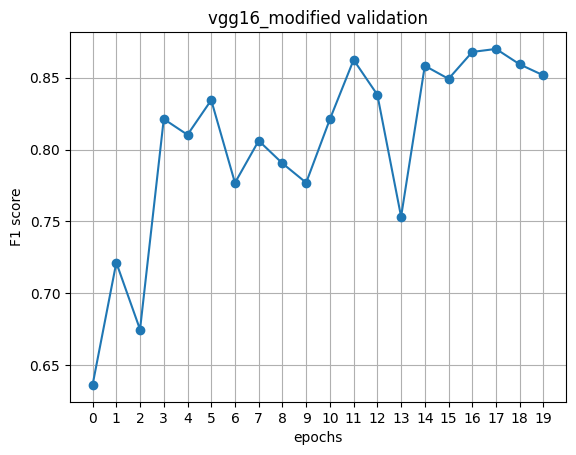

In [53]:
run_experiment(vgg16_modified)

#### EfficientNet-B0

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.3MB/s]


Epoch [1/20]
Train time = 12.7550 seconds, Train accuracy = 0.7240
Validation time = 4.2724 seconds, Validation F1 = 0.8290, Validation accuracy = 0.8470

Epoch [2/20]
Train time = 12.4118 seconds, Train accuracy = 0.9293
Validation time = 4.1999 seconds, Validation F1 = 0.8593, Validation accuracy = 0.8760

Epoch [3/20]
Train time = 12.4488 seconds, Train accuracy = 0.9542
Validation time = 4.5941 seconds, Validation F1 = 0.8601, Validation accuracy = 0.8813

Epoch [4/20]
Train time = 12.3441 seconds, Train accuracy = 0.9638
Validation time = 4.7463 seconds, Validation F1 = 0.8386, Validation accuracy = 0.8865

Epoch [5/20]
Train time = 12.5166 seconds, Train accuracy = 0.9734
Validation time = 4.2146 seconds, Validation F1 = 0.8613, Validation accuracy = 0.8997

Epoch [6/20]
Train time = 12.5931 seconds, Train accuracy = 0.9729
Validation time = 4.3312 seconds, Validation F1 = 0.8540, Validation accuracy = 0.8734

Epoch [7/20]
Train time = 12.4649 seconds, Train accuracy = 0.9745
Val

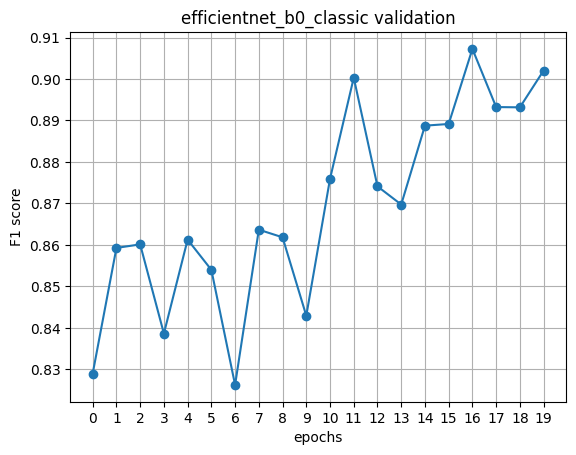

In [54]:
run_experiment(efficientnet_b0_classic)

Epoch [1/20]
Train time = 10.6208 seconds, Train accuracy = 0.5554
Validation time = 5.0100 seconds, Validation F1 = 0.6495, Validation accuracy = 0.7098

Epoch [2/20]
Train time = 10.2761 seconds, Train accuracy = 0.7472
Validation time = 4.9999 seconds, Validation F1 = 0.6981, Validation accuracy = 0.7441

Epoch [3/20]
Train time = 10.6616 seconds, Train accuracy = 0.7755
Validation time = 4.6042 seconds, Validation F1 = 0.7406, Validation accuracy = 0.7731

Epoch [4/20]
Train time = 10.9129 seconds, Train accuracy = 0.7896
Validation time = 4.3314 seconds, Validation F1 = 0.7387, Validation accuracy = 0.7704

Epoch [5/20]
Train time = 10.9245 seconds, Train accuracy = 0.7856
Validation time = 4.3461 seconds, Validation F1 = 0.7181, Validation accuracy = 0.7757

Epoch [6/20]
Train time = 10.8191 seconds, Train accuracy = 0.8309
Validation time = 4.2844 seconds, Validation F1 = 0.7402, Validation accuracy = 0.7863

Epoch [7/20]
Train time = 10.8264 seconds, Train accuracy = 0.8122
Val

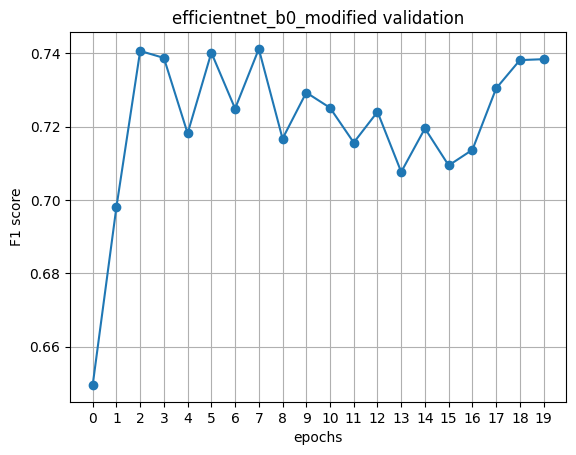

In [55]:
run_experiment(efficientnet_b0_modified)

#### Shufflenet_v2

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 38.0MB/s]


Epoch [1/20]
Train time = 11.2085 seconds, Train accuracy = 0.6340
Validation time = 4.0115 seconds, Validation F1 = 0.6273, Validation accuracy = 0.7361

Epoch [2/20]
Train time = 11.0515 seconds, Train accuracy = 0.8060
Validation time = 4.0288 seconds, Validation F1 = 0.6859, Validation accuracy = 0.7968

Epoch [3/20]
Train time = 11.0823 seconds, Train accuracy = 0.8914
Validation time = 4.1147 seconds, Validation F1 = 0.7730, Validation accuracy = 0.8259

Epoch [4/20]
Train time = 11.0015 seconds, Train accuracy = 0.9378
Validation time = 4.5384 seconds, Validation F1 = 0.8713, Validation accuracy = 0.8813

Epoch [5/20]
Train time = 10.7694 seconds, Train accuracy = 0.9627
Validation time = 5.1186 seconds, Validation F1 = 0.8646, Validation accuracy = 0.8813

Epoch [6/20]
Train time = 10.8806 seconds, Train accuracy = 0.9717
Validation time = 4.7259 seconds, Validation F1 = 0.8679, Validation accuracy = 0.8786

Epoch [7/20]
Train time = 11.0970 seconds, Train accuracy = 0.9825
Val

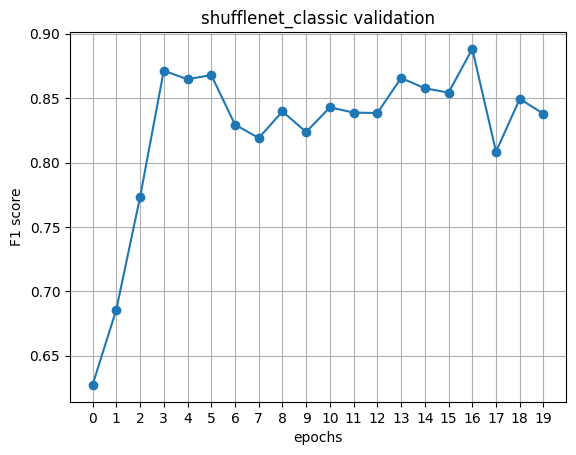

In [56]:
run_experiment(shufflenet_classic)

Epoch [1/20]
Train time = 10.3614 seconds, Train accuracy = 0.6408
Validation time = 4.0550 seconds, Validation F1 = 0.3917, Validation accuracy = 0.4670

Epoch [2/20]
Train time = 10.2607 seconds, Train accuracy = 0.8394
Validation time = 4.0316 seconds, Validation F1 = 0.7039, Validation accuracy = 0.7836

Epoch [3/20]
Train time = 10.2596 seconds, Train accuracy = 0.8801
Validation time = 4.0425 seconds, Validation F1 = 0.7743, Validation accuracy = 0.8232

Epoch [4/20]
Train time = 10.5313 seconds, Train accuracy = 0.9027
Validation time = 4.0181 seconds, Validation F1 = 0.8081, Validation accuracy = 0.8522

Epoch [5/20]
Train time = 10.2236 seconds, Train accuracy = 0.9146
Validation time = 4.0463 seconds, Validation F1 = 0.8096, Validation accuracy = 0.8549

Epoch [6/20]
Train time = 10.4228 seconds, Train accuracy = 0.9304
Validation time = 4.4290 seconds, Validation F1 = 0.7753, Validation accuracy = 0.8338

Epoch [7/20]
Train time = 10.1091 seconds, Train accuracy = 0.9299
Val

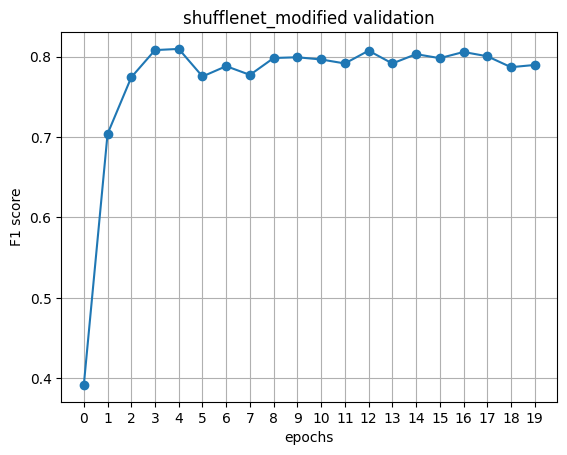

In [57]:
run_experiment(shufflenet_modified)

#### MobileNetV2

Epoch [1/20]
Train time = 12.0685 seconds, Train accuracy = 0.7093
Validation time = 4.1161 seconds, Validation F1 = 0.7761, Validation accuracy = 0.7942

Epoch [2/20]
Train time = 12.1775 seconds, Train accuracy = 0.9310
Validation time = 4.2191 seconds, Validation F1 = 0.8104, Validation accuracy = 0.8417

Epoch [3/20]
Train time = 12.1416 seconds, Train accuracy = 0.9598
Validation time = 4.4356 seconds, Validation F1 = 0.8225, Validation accuracy = 0.8707

Epoch [4/20]
Train time = 12.2562 seconds, Train accuracy = 0.9700
Validation time = 4.9512 seconds, Validation F1 = 0.8201, Validation accuracy = 0.8602

Epoch [5/20]
Train time = 12.3403 seconds, Train accuracy = 0.9757
Validation time = 4.2688 seconds, Validation F1 = 0.8891, Validation accuracy = 0.9077

Epoch [6/20]
Train time = 12.3085 seconds, Train accuracy = 0.9757
Validation time = 4.2841 seconds, Validation F1 = 0.8052, Validation accuracy = 0.8417

Epoch [7/20]
Train time = 12.3456 seconds, Train accuracy = 0.9717
Val

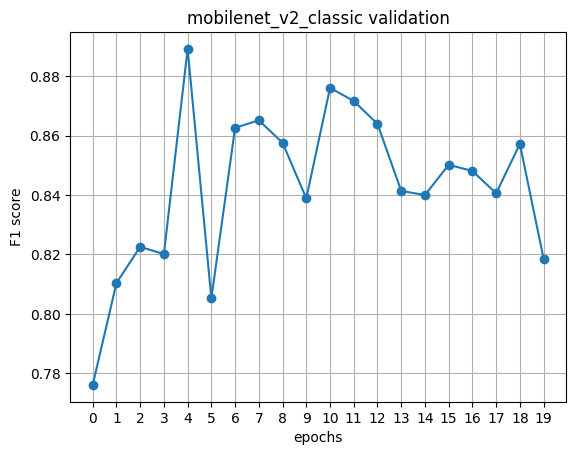

In [58]:
run_experiment(mobilenet_v2_classic)

Epoch [1/20]
Train time = 10.8652 seconds, Train accuracy = 0.6957
Validation time = 4.2461 seconds, Validation F1 = 0.7316, Validation accuracy = 0.7599

Epoch [2/20]
Train time = 11.1695 seconds, Train accuracy = 0.8546
Validation time = 4.3009 seconds, Validation F1 = 0.7344, Validation accuracy = 0.7757

Epoch [3/20]
Train time = 11.3517 seconds, Train accuracy = 0.9072
Validation time = 4.5155 seconds, Validation F1 = 0.7521, Validation accuracy = 0.7916

Epoch [4/20]
Train time = 10.8815 seconds, Train accuracy = 0.9446
Validation time = 5.0743 seconds, Validation F1 = 0.7696, Validation accuracy = 0.8074

Epoch [5/20]
Train time = 10.7254 seconds, Train accuracy = 0.9689
Validation time = 4.9423 seconds, Validation F1 = 0.7504, Validation accuracy = 0.7916

Epoch [6/20]
Train time = 11.1438 seconds, Train accuracy = 0.9717
Validation time = 4.4302 seconds, Validation F1 = 0.7643, Validation accuracy = 0.8074

Epoch [7/20]
Train time = 11.1300 seconds, Train accuracy = 0.9785
Val

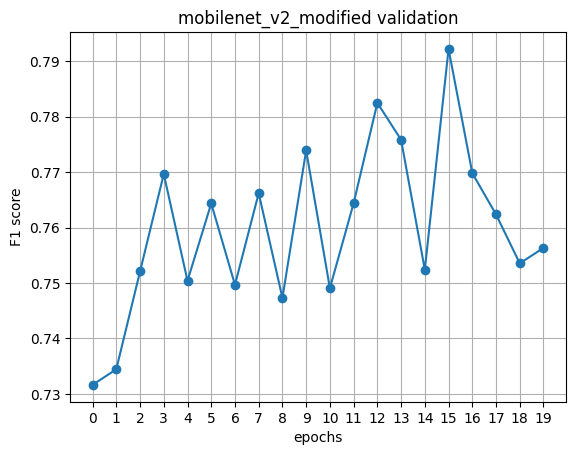

In [59]:
run_experiment(mobilenet_v2_modified)

## Диаграмма точностей

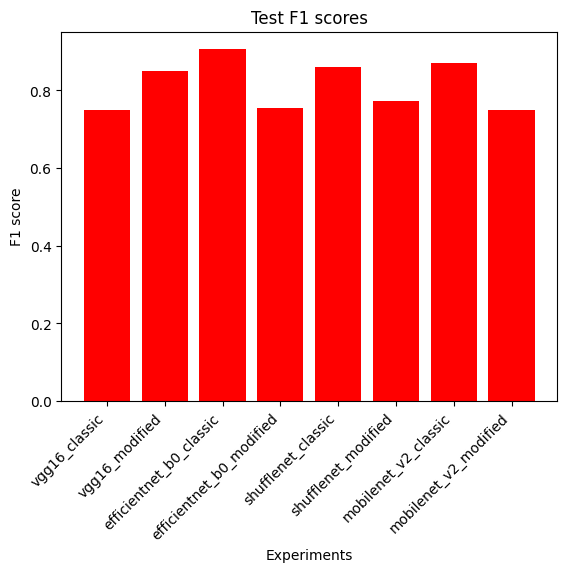

In [60]:
model_names = [*test_f1_stat.keys()]
f1_scores = [*test_f1_stat.values()]
plt.bar(model_names, f1_scores, color = "r")
plt.xlabel("Experiments")
plt.ylabel("F1 score")
plt.title("Test F1 scores")
plt.xticks(rotation = 45, ha = "right")
plt.show()